#  Spondylolisthesis Classification

This notebook trains classifiers to detect spondylolisthesis in MRI scans, using automated labels from the LLM pipeline.

In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import misvm
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

ivd_arrays_path = '/work/robinpark/AutoLabelClassifier/data/osclmric_ivd_arrays/april2024_splits'

In [2]:
# Pickle the dictionary
with open(f'{ivd_arrays_path}/spon_samples_dict.pkl', 'rb') as handle:
    samples = pickle.load(handle)

In [3]:
train_samples = samples['train_samples']
val_samples = samples['val_samples']
test_samples = samples['test_samples']

In [4]:
# Summarise splits
def sum_samples(samples):
    df = pd.DataFrame.from_dict(samples, orient='index', columns=['results']).reset_index()

    # Split index into columns
    df[['pat_id','date','level']] = df['index'].str.split('_',expand=True)

    # Sum rows by pat_id, date, level, and unique results 
    df = df.groupby(['pat_id','date','level','results']).size().reset_index(name='counts')

    df['pat_stu_id'] = df['pat_id'] + '_' + df['date']

    print('unique pat:', len(df[['pat_id']].drop_duplicates()))
    print('unique studies:', len(df[['pat_stu_id']].drop_duplicates()))

    display(df.groupby(['results'])[['counts']].sum())

In [5]:
df = pd.DataFrame.from_dict(train_samples, orient='index', columns=['results']).reset_index()

# Split index into columns
df[['pat_id','date','level']] = df['index'].str.split('_',expand=True)

# Sum rows by pat_id, date, level, and unique results 
df = df.groupby(['pat_id','date','level','results']).size().reset_index(name='counts')

df['pat_id_date'] = df['pat_id'] + '_' + df['date']

In [6]:
sum_samples(train_samples)

unique pat: 1358
unique studies: 1923


,counts
results,
0,5033
1,725


In [7]:
sum_samples(val_samples)

unique pat: 151
unique studies: 216


,counts
results,
0,567
1,78


In [8]:
sum_samples(test_samples)

unique pat: 146
unique studies: 151


,counts
results,
0,240
1,213


## ResNet Encodings + SVC

In [9]:
with open(f'{ivd_arrays_path}/spon_resnet_encodings.pkl', 'rb') as handle:
    ce_resnet_encodings = pickle.load(handle)

train_features_cpu = ce_resnet_encodings['train_features_cpu']
label_train_array = ce_resnet_encodings['label_train_array']

val_features_cpu = ce_resnet_encodings['val_features_cpu']
label_val_array = ce_resnet_encodings['label_val_array']

test_features_cpu = ce_resnet_encodings['test_features_cpu']
label_test_array = ce_resnet_encodings['label_test_array']

In [10]:
# Load pickled arrays
with open(f'{ivd_arrays_path}/spon_arrays_dict.pkl', 'rb') as handle:
    ce_array_dict = pickle.load(handle)

label_test_report = ce_array_dict['label_test_report']
label_test_scores = ce_array_dict['label_test_scores']
label_test_con = ce_array_dict['label_test_con']
compare_test_array = ce_array_dict['compare_test_array']

test_pat_id_date = ce_array_dict['test_pat_id_date']
val_pat_id_date = ce_array_dict['val_pat_id_date']
train_pat_id_date = ce_array_dict['train_pat_id_date']

In [11]:
# Standardise
scaler = StandardScaler()
train_features_cpu = scaler.fit_transform(train_features_cpu)
val_features_cpu = scaler.transform(val_features_cpu)
test_features_cpu = scaler.transform(test_features_cpu)

In [12]:
train_features_cpu = [torch.Tensor(i) for i in train_features_cpu]
val_features_cpu = [torch.Tensor(i) for i in val_features_cpu]
test_features_cpu = [torch.Tensor(i) for i in test_features_cpu]

### MIL-SVM

In [13]:
def create_mil_bags(features, labels, patient_slices):
    # Combine features, labels, and patient slices into a DataFrame
    df = pd.DataFrame({'Features': features, 'Labels': labels, 'Patient_Slices': patient_slices})
    
    # Group by patient
    grouped = df.groupby('Patient_Slices')
    
    mil_bags = []
    mil_label = []
    
    for patient_slice, group in grouped:
        bag_features = group['Features'].tolist()
        
        bag_label = group['Labels'].max()
        if bag_label == 0:
            bag_label = -1
        
        # Add bag to MIL bags
        mil_bags.append(bag_features)
        mil_label.append(bag_label)
    
    return mil_bags, mil_label

In [14]:
# Remove _ if found at end of element
train_pat_id_date = [i[:-1] if i[-1] == '_' else i for i in train_pat_id_date]
val_pat_id_date = [i[:-1] if i[-1] == '_' else i for i in val_pat_id_date]

# Remove _T if found at end of element
train_pat_id_date = [i[:-2] if i[-2] == '_T' else i for i in train_pat_id_date]
val_pat_id_date = [i[:-2] if i[-2] == '_T' else i for i in val_pat_id_date]

In [15]:
train_bags, train_labels = create_mil_bags(train_features_cpu, label_train_array, train_pat_id_date)
test_bags, test_labels = create_mil_bags(test_features_cpu, label_test_array, test_pat_id_date)
val_bags, val_labels = create_mil_bags(val_features_cpu, label_val_array, val_pat_id_date)

In [16]:
def eval_mil(model):

    mil_val_scores = model.predict(val_bags)
    mil_val_pred = np.sign(mil_val_scores)

    fpr, tpr, thresholds = roc_curve(val_labels, mil_val_scores)

    # Find the point where FPR equals FRR
    val_eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    val_eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]  # Equal to FRR

    print('Validation Balanced Accuracy:', balanced_accuracy_score(val_labels, mil_val_pred))
    print('Validation F1 Score:', f1_score(val_labels, mil_val_pred))
    print('Validation AUC:', roc_auc_score(val_labels, mil_val_scores))
    print('Validation EER:', val_eer)
    print('Validation EER Threshold:', val_eer_threshold)

    mil_test_scores = model.predict(test_bags)
    mil_test_pred = np.where(mil_test_scores > val_eer_threshold, 1, -1)

    fpr, tpr, thresholds = roc_curve(test_labels, mil_test_scores)

    # Find the point where FPR equals FRR
    test_eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    test_eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]  # Equal to FRR

    print('\nTest Balanced Accuracy:', balanced_accuracy_score(test_labels, mil_test_pred))
    print('Test F1 Score:', f1_score(test_labels, mil_test_pred))
    print('Test AUC:', roc_auc_score(test_labels, mil_test_scores))
    print('Test EER:', test_eer)
    print('Test EER Threshold:', test_eer_threshold)

    display_labels = ['No Spon', 'Spon']
    class_report = classification_report(test_labels, mil_test_pred, target_names=display_labels)
    conf_mat = confusion_matrix(test_labels, mil_test_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return mil_test_pred, mil_test_scores

### Resample

In [17]:
# Separate positive and negative bags
pos_train_bags = [bag for bag, label in zip(train_bags, train_labels) if label == 1]
neg_train_bags = [bag for bag, label in zip(train_bags, train_labels) if label == -1]

In [18]:
len(pos_train_bags)

243

In [19]:
len(neg_train_bags)

1680

In [20]:
# Double the negative examples to balance
pos_train_bags_rs = pos_train_bags * 7
neg_train_bags_rs = neg_train_bags[:len(pos_train_bags_rs)]

train_bags_rs = pos_train_bags_rs + neg_train_bags_rs
train_labels_rs = [1] * len(pos_train_bags_rs) + [-1] * len(neg_train_bags_rs)

In [21]:
# Count the values in train_lables
unique, counts = np.unique(train_labels_rs, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  -1 1680]
 [   1 1701]]


#### SIL
Applying bag-level label to every instance

In [22]:
sil_svm = misvm.SIL(kernel='linear', C=1)
sil_svm.fit(train_bags_rs, train_labels_rs)

     pcost       dcost       gap    pres   dres
 0: -3.2114e+03 -5.5274e+00  1e+05  4e+02  1e-11
 1: -5.0361e+01 -5.4078e+00  2e+03  5e+00  1e-11
 2: -4.7968e+00 -3.5130e+00  1e+02  3e-01  6e-13
 3: -9.9211e-01 -3.0111e+00  1e+01  3e-02  5e-14
 4: -6.2455e-01 -2.1557e+00  2e+00  1e-03  4e-15
 5: -6.7860e-01 -9.9087e-01  3e-01  2e-04  2e-15
 6: -7.4660e-01 -8.4773e-01  1e-01  4e-05  2e-15
 7: -7.7063e-01 -8.0679e-01  4e-02  1e-05  2e-15
 8: -7.8172e-01 -7.8965e-01  8e-03  2e-06  2e-15
 9: -7.8418e-01 -7.8624e-01  2e-03  2e-07  2e-15
10: -7.8495e-01 -7.8531e-01  4e-04  3e-08  2e-15
11: -7.8509e-01 -7.8514e-01  5e-05  4e-09  2e-15
12: -7.8511e-01 -7.8512e-01  5e-06  9e-17  2e-15
13: -7.8512e-01 -7.8512e-01  1e-07  2e-16  2e-15
Optimal solution found.


Validation Balanced Accuracy: 0.7002024291497976
Validation F1 Score: 0.3262411347517731
Validation AUC: 0.7682186234817814
Validation EER: 0.24210526315789474
Validation EER Threshold: 0.41823805816291404

Test Balanced Accuracy: 0.7599471830985915
Test F1 Score: 0.7428571428571429
Test AUC: 0.8433098591549296
Test EER: 0.2625
Test EER Threshold: 0.37245200596293604
              precision    recall  f1-score   support

     No Spon       0.77      0.79      0.78        80
        Spon       0.75      0.73      0.74        71

    accuracy                           0.76       151
   macro avg       0.76      0.76      0.76       151
weighted avg       0.76      0.76      0.76       151



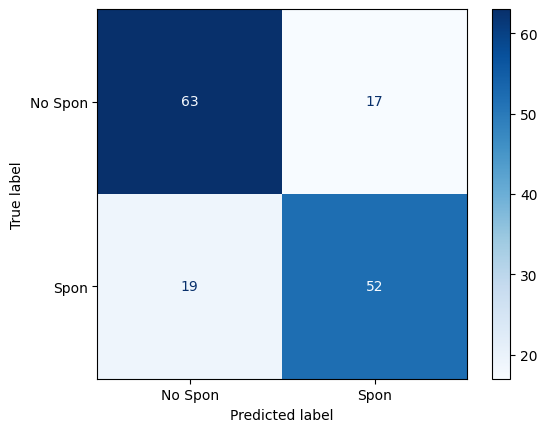

In [23]:
sil_test_pred, sil_test_scores = eval_mil(sil_svm)

#### MISVM 
Maximising bag margin with max positive instance for positive bags and min negative instance for negative bags (Andrews, Tsochantaridis, Hofmann, 2002)

In [24]:
MISVM = misvm.MISVM(kernel='linear', C=10)
MISVM.fit(train_bags_rs, train_labels_rs)

Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -1.5050e+03 -1.6050e+01  6e+04  2e+02  6e-12
 1: -2.3312e+01 -1.5954e+01  8e+02  3e+00  6e-12
 2: -4.1564e+00 -1.4980e+01  4e+01  1e-01  2e-13
 3: -3.2812e+00 -1.0126e+01  1e+01  2e-02  4e-14
 4: -3.4648e+00 -5.2008e+00  2e+00  3e-03  1e-14
 5: -3.7610e+00 -4.6735e+00  1e+00  1e-03  8e-15
 6: -3.9525e+00 -4.3707e+00  4e-01  4e-04  8e-15
 7: -4.0260e+00 -4.2736e+00  3e-01  2e-04  9e-15
 8: -4.0815e+00 -4.2055e+00  1e-01  8e-05  9e-15
 9: -4.1171e+00 -4.1665e+00  5e-02  3e-05  1e-14
10: -4.1361e+00 -4.1468e+00  1e-02  1e-06  1e-14
11: -4.1408e+00 -4.1434e+00  3e-03  3e-07  2e-14
12: -4.1422e+00 -4.1425e+00  3e-04  2e-08  2e-14
13: -4.1423e+00 -4.1424e+00  1e-05  9e-10  4e-14
14: -4.1424e+00 -4.1424e+00  4e-07  2e-11  2e-13
Optimal solution found.
Recomputing classes...
Selector differences: 6734
Updating QP...

Iteration 2...
Training SVM...
     pcost       dcost       gap    pres   d

Validation Balanced Accuracy: 0.6997975708502024
Validation F1 Score: 0.3855421686746988
Validation AUC: 0.7825910931174089
Validation EER: 0.28421052631578947
Validation EER Threshold: -0.20102937689288447

Test Balanced Accuracy: 0.7779929577464788
Test F1 Score: 0.7763157894736842
Test AUC: 0.8890845070422535
Test EER: 0.2
Test EER Threshold: -0.06034072043001548
              precision    recall  f1-score   support

     No Spon       0.83      0.72      0.77        80
        Spon       0.73      0.83      0.78        71

    accuracy                           0.77       151
   macro avg       0.78      0.78      0.77       151
weighted avg       0.78      0.77      0.77       151



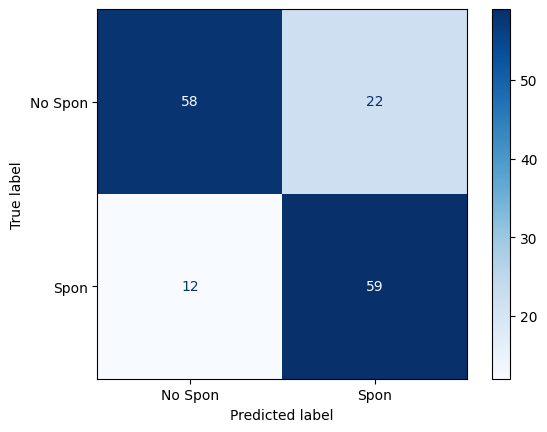

In [25]:
mi_test_pred, mi_test_scores = eval_mil(MISVM)

### NSK-SVM
Maps entire bags to features, using distance between two bags to generate the kernel (Gärtner et al, 2002)

In [26]:
nsk_svm = misvm.NSK(kernel='linear_av', C=10)
nsk_svm.fit(train_bags_rs, train_labels_rs)

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -6.3282e+02 -3.6171e+01  3e+04  2e+02  3e-12
 1: -3.7600e+01 -3.1939e+01  1e+03  7e+00  3e-12
 2: -8.8453e+00 -2.6238e+01  1e+02  6e-01  3e-13
 3: -4.7895e+00 -2.0710e+01  2e+01  4e-02  3e-14
 4: -4.9639e+00 -8.6510e+00  4e+00  7e-03  9e-15
 5: -5.5205e+00 -6.6764e+00  1e+00  1e-03  8e-15
 6: -5.7416e+00 -6.1875e+00  5e-01  3e-04  9e-15
 7: -5.8397e+00 -5.9854e+00  1e-01  7e-05  9e-15
 8: -5.8720e+00 -5.9244e+00  5e-02  2e-05  9e-15
 9: -5.8859e+00 -5.8992e+00  1e-02  9e-07  9e-15
10: -5.8907e+00 -5.8925e+00  2e-03  9e-08  9e-15
11: -5.8913e+00 -5.8915e+00  2e-04  8e-09  9e-15
12: -5.8914e+00 -5.8914e+00  1e-05  5e-10  9e-15
13: -5.8914e+00 -5.8914e+00  5e-06  1e-10  9e-15
Optimal solution found.


Validation Balanced Accuracy: 0.7050607287449393
Validation F1 Score: 0.3950617283950617
Validation AUC: 0.7850202429149797
Validation EER: 0.32105263157894737
Validation EER Threshold: -0.26889001314055155

Test Balanced Accuracy: 0.7803697183098591
Test F1 Score: 0.7848101265822784
Test AUC: 0.8549295774647887
Test EER: 0.25
Test EER Threshold: -0.033293017504112066
              precision    recall  f1-score   support

     No Spon       0.86      0.69      0.76        80
        Spon       0.71      0.87      0.78        71

    accuracy                           0.77       151
   macro avg       0.79      0.78      0.77       151
weighted avg       0.79      0.77      0.77       151



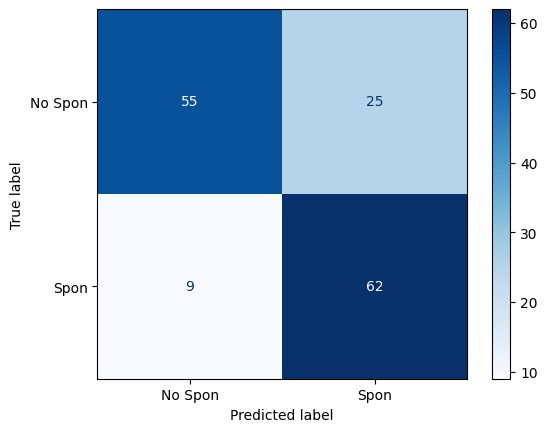

In [27]:
mil_test_pred, mil_test_scores = eval_mil(nsk_svm)

## SpineNetv2 Classifier

In [28]:
with open(f'{ivd_arrays_path}/spon_spinenet_encodings.pkl', 'rb') as handle:
    osclmric_spinenet_encodings = pickle.load(handle)

ivd_train_encodings = osclmric_spinenet_encodings['ivd_train_encodings'] 
label_train_array = osclmric_spinenet_encodings['label_train_array'] 
spnt_label_train_array = osclmric_spinenet_encodings['spnt_label_train_array'] 

ivd_val_encodings = osclmric_spinenet_encodings['ivd_val_encodings'] 
label_val_array = osclmric_spinenet_encodings['label_val_array'] 
spnt_label_val_array = osclmric_spinenet_encodings['spnt_label_val_array'] 

ivd_test_encodings = osclmric_spinenet_encodings['ivd_test_encodings'] 
label_test_array = osclmric_spinenet_encodings['label_test_array']
spnt_label_test_array = osclmric_spinenet_encodings['spnt_label_test_array']


In [29]:
def create_sp_mil_bags(features, labels, sp_labels, patient_slices):
    # Combine features, labels, and patient slices into a DataFrame
    df = pd.DataFrame({'Features': features, 'Labels': labels, 'Spinenet_Labels': sp_labels, 'Patient_Slices': patient_slices})
    
    # Group by patient
    grouped = df.groupby('Patient_Slices')
    
    mil_bags = []
    mil_label = []
    sp_mil_label = []
    
    for patient_slice, group in grouped:
        bag_features = group['Features'].tolist()
        
        bag_label = group['Labels'].max()
        if bag_label == 0:
            bag_label = -1

        sp_bag_label = group['Spinenet_Labels'].max()
        if sp_bag_label == 0:
            sp_bag_label = -1
        
        # Add bag to MIL bags
        mil_bags.append(bag_features)
        mil_label.append(bag_label)
        sp_mil_label.append(sp_bag_label)
    
    return mil_bags, mil_label, sp_mil_label

In [30]:
train_bags, train_labels, sp_train_labels = create_sp_mil_bags(ivd_train_encodings, label_train_array, spnt_label_train_array, train_pat_id_date)
test_bags, test_labels, sp_test_labels = create_sp_mil_bags(ivd_test_encodings, label_test_array, spnt_label_test_array, test_pat_id_date)
val_bags, val_labels, sp_val_labels = create_sp_mil_bags(ivd_val_encodings, label_val_array, spnt_label_val_array, val_pat_id_date)

In [31]:
# Classifier performance 
acc = (np.array(sp_test_labels) == np.array(test_labels)).sum() / len(label_test_array)
bal_acc = balanced_accuracy_score(test_labels, sp_test_labels)
f1 = f1_score(test_labels, sp_test_labels)
print(f'Balanced Accuracy: {bal_acc:.3f}')
print(f'F1: {f1:.3f}')

Balanced Accuracy: 0.861
F1: 0.853


In [32]:
# Separate positive and negative bags
pos_train_bags = [bag for bag, label in zip(train_bags, train_labels) if label == 1]
neg_train_bags = [bag for bag, label in zip(train_bags, train_labels) if label == -1]

In [33]:
# Double the negative examples to balance
pos_train_bags_rs = pos_train_bags * 7
neg_train_bags_rs = neg_train_bags[:len(pos_train_bags_rs)]

train_bags_rs = pos_train_bags_rs + neg_train_bags_rs
train_labels_rs = [1] * len(pos_train_bags_rs) + [-1] * len(neg_train_bags_rs)

In [34]:
nsk_svm = misvm.NSK(kernel='linear_av', C=10)
nsk_svm.fit(train_bags_rs, train_labels_rs)

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -9.8283e+02 -6.2450e+01  3e+04  2e+02  1e-12
 1: -7.1535e+01 -3.1705e+01  1e+03  8e+00  2e-12
 2: -1.0039e+01 -2.6531e+01  1e+02  5e-01  1e-13
 3: -6.0971e+00 -1.8691e+01  1e+01  2e-03  1e-14
 4: -6.7851e+00 -9.1018e+00  2e+00  3e-04  9e-15
 5: -7.3149e+00 -8.0011e+00  7e-01  5e-05  9e-15
 6: -7.4715e+00 -7.7441e+00  3e-01  1e-05  1e-14
 7: -7.5441e+00 -7.6320e+00  9e-02  4e-06  1e-14
 8: -7.5705e+00 -7.5948e+00  2e-02  8e-07  1e-14
 9: -7.5792e+00 -7.5833e+00  4e-03  8e-08  1e-14
10: -7.5809e+00 -7.5812e+00  3e-04  5e-09  1e-14
11: -7.5811e+00 -7.5811e+00  6e-06  1e-10  1e-14
Optimal solution found.


Validation Balanced Accuracy: 0.7311740890688259
Validation F1 Score: 0.3958333333333333
Validation AUC: 0.8119433198380567
Validation EER: 0.26842105263157895
Validation EER Threshold: 0.004135296860261317

Test Balanced Accuracy: 0.8577464788732394
Test F1 Score: 0.8552631578947368
Test AUC: 0.9107394366197182
Test EER: 0.1375
Test EER Threshold: 0.18712643037657686
              precision    recall  f1-score   support

     No Spon       0.91      0.80      0.85        80
        Spon       0.80      0.92      0.86        71

    accuracy                           0.85       151
   macro avg       0.86      0.86      0.85       151
weighted avg       0.86      0.85      0.85       151



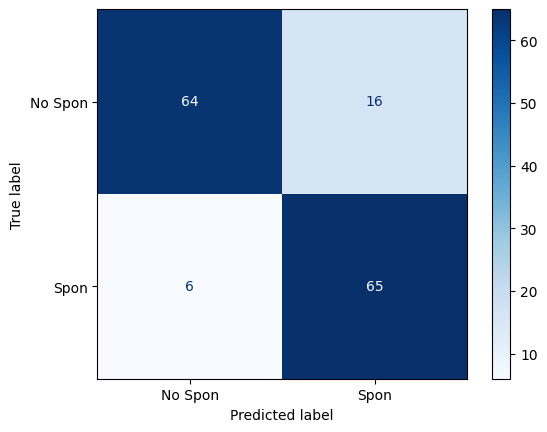

In [35]:
sp_mil_test_pred, sp_mil_test_scores = eval_mil(nsk_svm)

### Visualise Results

In [36]:
# Load pickled arrays
with open(f'{ivd_arrays_path}/spon_arrays_dict.pkl', 'rb') as handle:
    ncimi_array_dict = pickle.load(handle)

ivd_train_array = ncimi_array_dict['ivd_train_array']
label_train_array = ncimi_array_dict['label_train_array']

ivd_val_array = ncimi_array_dict['ivd_val_array']
label_val_array = ncimi_array_dict['label_val_array']

ivd_test_array = ncimi_array_dict['ivd_test_array']
label_test_array = ncimi_array_dict['label_test_array']
label_test_report = ncimi_array_dict['label_test_report']
label_test_scores = ncimi_array_dict['label_test_scores']
label_test_con = ncimi_array_dict['label_test_con']
compare_test_array = ncimi_array_dict['compare_test_array']
ivd_test_array_names = []

In [37]:
def mil_level_report(
    label_test_report, label_test_con, label_test_scores, 
    compare_test_array, ivd_test_array, #ivd_test_array_names, 
    patient_slices):
    # Combine features, labels, and patient slices into a DataFrame
    df = pd.DataFrame(
        {'Reports': label_test_report, 
        'Conclusions': label_test_con, 
        'Label Scores': label_test_scores,
        'Predicted Label': compare_test_array,
        'IVD Test Array': ivd_test_array,
        #'IVD Names': ivd_test_array_names,
        'Patient Slices': patient_slices})

    # Group by patient
    grouped = df.groupby('Patient Slices')
    
    bag_report = []
    bag_con = []
    bag_score = []
    bag_pred_label = []
    bag_ivd_test_array = []
    #bag_names = []
    
    for patient_slice, group in grouped:
        # Combine slices into a bag
        
        bag_report.append(group['Reports'].iloc[0])
        bag_con.append(group['Conclusions'].iloc[0])
        bag_score.append(group['Label Scores'].iloc[0])
        bag_pred_label.append(group['Predicted Label'].iloc[0])
        bag_ivd_test_array.append(group['IVD Test Array'].tolist())
        #bag_names.append(group['IVD Names'].tolist())
    
    return bag_report, bag_con, bag_score, bag_pred_label, bag_ivd_test_array, #bag_names

(df_lab_test_report, 
 df_lab_test_con, 
 df_lab_test_scores, 
 df_lab_pred_labels, 
 #bag_ivd_test_array, 
 bag_of_names) = mil_level_report(label_test_report, 
                                  label_test_con, 
                                  label_test_scores, 
                                  compare_test_array, 
                                  ivd_test_array, 
                                  #ivd_test_array_names, 
                                  test_pat_id_date)

In [38]:
# # Visualise outputs at each step 
# counter = 20
# zipped_results = list(zip(df_lab_test_report, df_lab_test_con, df_lab_test_scores, df_lab_pred_labels, test_labels, mil_test_pred, mil_test_scores, #bag_ivd_test_array, 
# bag_of_names))

# for report, pred_con, pred_report_score, pred_report_label, true_report_label, pred_scan_label, pred_scan_score, ivd_name in zipped_results: #ivd, 
#     if counter <25:
#         if pred_report_label == 1 and true_report_label == 1 and pred_scan_label == 1:
#             counter += 1
#             print(f'Report: {report}')
#             print(f'Conclusion: {pred_con}')
#             print(f'Predicted Report Score: {pred_report_score}')
#             print(f'Predicted Report Label: {pred_report_label}')
#             print(f'True Report Label: {true_report_label}')
#             print(f'Predicted Scan Label: {pred_scan_label}')
#             print(f'Predicted Scan Score: {pred_scan_score}')
#             # Plot ivd
#             # for i in range(len(ivd)):
#             for i in range(len(ivd_name)):
#                 #print(f'IVD: {ivd_name[i]}')
#                 plt.imshow(ivd_name[i][:,3,:,:][0], cmap='gray')
#                 plt.show()
#                 print('\n')
#     elif counter == 25:
#         break